<a href="https://colab.research.google.com/github/sevdanurcopur/DigitalBrain_Case/blob/main/Case_DigitalBrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.1 MB/s eta 0:00:00


In [ ]:
# Temel veri işleme kütüphaneleri
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import optuna


In [ ]:
def read_data(file_path):
    """
    Excel formatındaki veri setini okuyup dataframe formatına dönüştürmeyi sağlar

    Parametre :
    file_path: excel dosyasının dosya yolu

    return dataframe
    """
    df_1= pd.read_excel(file_path, sheet_name="Year 2009-2010")
    df_2=pd.read_excel(file_path, sheet_name="Year 2010-2011")

    print(f"Shape of the df_1 before merging", df_1.shape)
    print(f"Shape of the df_2 before merging", df_2.shape)
    df= pd.concat([df_1,df_2], ignore_index=False)

    return df


def check_df(dataframe, head=5):

    """
    Veri setine genel bir bakış atmayı sağlar
    Parametre :
    dataframe : okutulacak ve bilgi edinilecek olan dataframe
    head (int): İlk kaç satırın gösterileceği. Varsayılan değer 5'tir.
    """

    print("DataFrame'in ilk {} satırı:".format(head))
    display(dataframe.head(head))
    print("---------------------------------")

    print("DataFrame'in shape bilgisi:")
    display(dataframe.shape)
    print("---------------------------------")

    print("DataFrame hakkında genel bilgiler:")
    dataframe.info()
    print("---------------------------------")

    print("DataFramede eksik değer bilgisi :")
    display(dataframe.isnull().sum())
    print("---------------------------------")
    return True


def observe_data(dataframe):

    print("DataFrame'in eşsiz urun sayisi nedir :")
    print(df["Description"].nunique())
    print("---------------------------------")

    # eşsiz fatura sayısı
    print("DataFrame'in eşsiz fatura sayısı nedir :")
    print(df["Invoice"].nunique())
    print("---------------------------------")

    print("DataFrame'in eşsiz customer sayısı  nedir :")
    print(df["Customer ID"].nunique())
    print("---------------------------------")

    print("DataFrame'in bir müşteri oluşturduüu fatura sayıları farklı mı aynı mı :")
    print(dataframe.groupby("Customer ID").agg({"Invoice":"nunique"}).head() )


def missing_values(dataframe):
    """
    Quantity de 0 dan düşük olan satırları veri setinden kaldırıyoruz
    Invoice değerlerinin C olması iptal olduğunu göstermektedir
    Eksik değerleri ise (description ve CustomerId leri düşürüyoruz )
    """
    dataframe= dataframe[dataframe["Quantity"]>0]
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe.dropna(inplace=True)

    return dataframe


def change_type(dataframe):
    """
    Belirli sütunların veri tiplerini dönüştürür.
    Parametreler:
    dataframe (pd.DataFrame): Veri tipleri dönüştürülecek DataFrame.

    return dataframe
    """
    dataframe["Customer ID"]=dataframe["Customer ID"].astype(int)
    dataframe["InvoiceDate"]=pd.to_datetime(dataframe["InvoiceDate"])

    return dataframe

# RFM Metriklerinin Hesaplanması

def calculate_total_price(dataframe):
    """
    Monetary değerini hesaplayabilmek için bir faturadan gelen toplam ücreti hesaplamak gerekmektedir
    """
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    return dataframe


def calculate_today_date(dataframe, days=2):
    """
    Verilen DataFrame'deki en son sipariş tarihine göre bugünün tarihini hesaplar.
    Parametreler:
    Dataframe
    days (int): En son sipariş tarihine eklenecek gün sayısı. Varsayılan değer 2'dir.
    return dataframe
    """
    today_date= dataframe["InvoiceDate"].max()+ dt.timedelta(days=days)
    return today_date


def create_rfm(dataframe, today_date):
    """
    Verilen dataframe RFM (Recency, Frequency, Monetary) tablosu oluşturur.

    Parametreler:
    dataframe (pd.DataFrame): Müşteri işlem verilerini içeren girdi veri çerçevesi.
    today_date (datetime): Recency hesaplamak için referans tarih. Genellikle bugünün tarihi olarak kullanılır.

    Return:
    pd.DataFrame: 'recency', 'frequency' ve 'monetary' sütunlarını içeren RFM metriklerini içeren bir veri çerçevesi.
                  Negatif veya sıfır monetary değerine sahip satırlar hariç tutulur.

    - 'recency': Müşterinin son satın alımından bu yana geçen gün sayısı.
    - 'frequency': Müşterinin benzersiz fatura sayısı.
    - 'monetary': Müşterinin toplam harcama değeri.

    """
    rfm = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days, # gün cinsinden ifade ediyor
                                     'Invoice': lambda Invoice: Invoice.nunique(),  # eşsiz değerlere bak fatura sayıları
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()}) # toplam fiyat

    rfm.columns= ['recency', 'frequency', 'monetary']
    rfm= rfm[rfm["monetary"]>0]

    return rfm


def calculate_rfm_scores(dataframe):
    """
    RFM skorlarını hesaplar ve RFM DataFrame'ine ekler.

    Recency ne kadar düşükse bizim için o kadar iyidir
    Frequency değeri ne kadar yüksekse müşteirnin sık geldiğini gösterir
    monetary değerinin de yüksek olması şirket için önemlidir bu husular göz önünde bulundurularak labellar belirlenmiştir

    Parametreler:
    rfm (pd.DataFrame): RFM metriklerini içeren DataFrame.

    Return :
    pd.DataFrame: RFM skorlarını içeren güncellenmiş DataFrame.
    """
    dataframe["recency_score"] = pd.qcut(dataframe['recency'].rank(method="first"), 5, labels=[5, 4, 3, 2, 1])
    dataframe["frequency_score"] = pd.qcut(dataframe["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    dataframe["monetary_score"] = pd.qcut(dataframe['monetary'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

    return  dataframe


def assign_rfm_segment(dataframe):
    """
    RFM skorlarına göre müşteri segmentlerini belirler ve RFM DataFrame'ine ekler.

    Parametreler:
    dataframe: RFM metriklerini içeren DataFrame.

    Return:
    pd.DataFrame: Müşteri segmentlerini içeren güncellenmiş DataFrame.
    """
    dataframe["RFM_SCORE"] = (dataframe['recency_score'].astype(str) +
                              dataframe['frequency_score'].astype(str))

    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    dataframe['segment'] = dataframe['RFM_SCORE'].replace(seg_map, regex=True)
    dataframe.reset_index(inplace=True)
    dataframe = dataframe[["Customer ID", "recency", "frequency", "monetary", "segment"]]
    return dataframe

In [ ]:
# veri setinin okutulması
df= read_data("/content/drive/MyDrive/Case-study/online_retail_II.xlsx")

# veri setine genel bir bakış

check_df(df)

# sütunların eşsiz değerlerine bakılması
observe_data(df)

# eksik sütunların değerlendirilmesi
df= missing_values(df)

# typeların düzeltilmesi
df= change_type(df)

# totalprice sütununun eklenmesi
df=calculate_total_price(df)

today_date= calculate_today_date(df)

# RFM metriklerinin hesaplanması
rfm= create_rfm(df,today_date)

# RFM skorlarının hesaplanması
rfm_score= calculate_rfm_scores(rfm)

# RFM skorlarına göre segmentlerin oluşturulması
rfm_score= assign_rfm_segment(rfm_score)



Shape of the df_1 before merging (525461, 8)
Shape of the df_2 before merging (541910, 8)
DataFrame'in ilk 5 satırı:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


---------------------------------
DataFrame'in shape bilgisi:


(1067371, 8)

---------------------------------
DataFrame hakkında genel bilgiler:
<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB
---------------------------------
DataFramede eksik değer bilgisi :


Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

---------------------------------
DataFrame'in eşsiz urun sayisi nedir :
5698
---------------------------------
DataFrame'in eşsiz fatura sayısı nedir :
53628
---------------------------------
DataFrame'in eşsiz customer sayısı  nedir :
5942
---------------------------------
DataFrame'in bir müşteri oluşturduüu fatura sayıları farklı mı aynı mı :
             Invoice
Customer ID         
12346.0           17
12347.0            8
12348.0            5
12349.0            5
12350.0            1


In [ ]:
rfm_score.head(10)

,Customer ID,recency,frequency,monetary,segment
0,12346,327,12,77556.46,cant_loose
1,12347,3,8,5633.32,champions
2,12348,76,5,2019.40,loyal_customers
3,12349,20,4,4428.69,potential_loyalists
4,12350,311,1,334.40,hibernating
5,12351,376,1,300.93,hibernating
6,12352,37,10,2849.84,loyal_customers
7,12353,205,2,406.76,hibernating
8,12354,233,1,1079.40,hibernating
9,12355,215,2,947.61,hibernating


,Customer ID
segment,
hibernating,1526
loyal_customers,1167
champions,830
at_risk,754
potential_loyalists,711
about_to_sleep,384
need_attention,268
promising,113
cant_loose,71


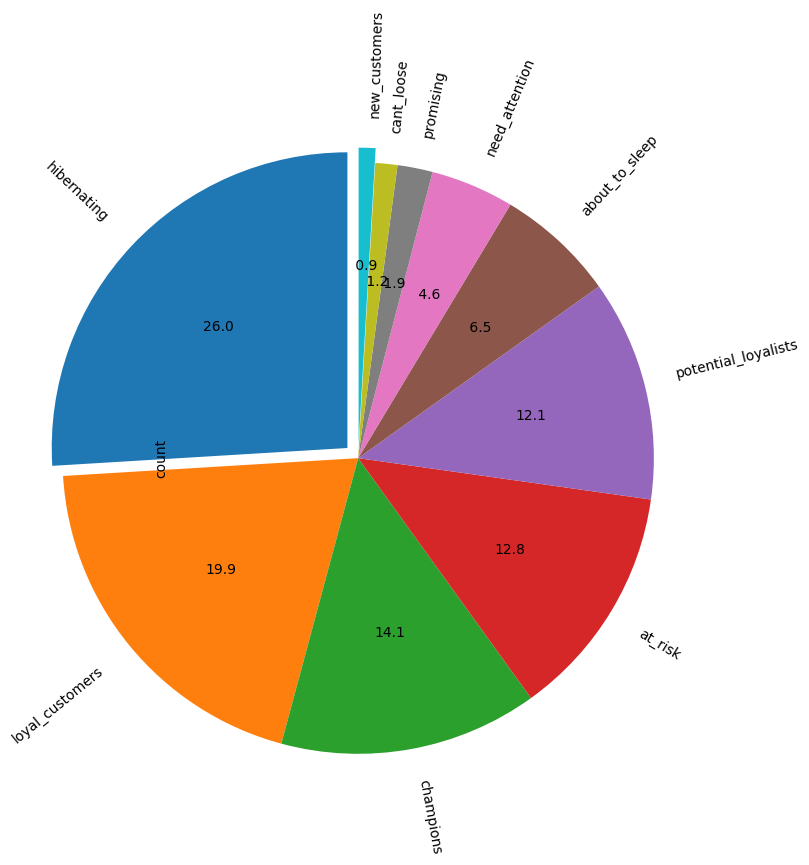

In [ ]:
# GÖRSELLEŞTİRME

## Segmentleri Görselleştirme

def plot_rfm_segments(rfm_score):
    explodes = [0.10, 0, 0, 0, 0, 0, 0, 0, 0, 0.1]
    rfm_score["segment"].value_counts(sort=True).plot.pie(
                                                    textprops={'fontsize': 10},
                                                    autopct = '%4.1f',
                                                    startangle= 90,
                                                    radius =2,
                                                    rotatelabels=True,
                                                    explode = explodes)


    segment_counts= rfm_score.groupby('segment').agg({"Customer ID":"count"}).sort_values("Customer ID",ascending=False)
    return segment_counts

plot_rfm_segments(rfm_score)

- **Hibernating (26.0%)** :  Bu müşteriler uzun süredir aktif değiller, yani Recency skorları yüksek, Frequency skorları düşük.Bu müşterileri yeniden kazanmak için yeniden etkileşim kampanyaları düzenlenmeli, özel indirimler ve hatırlatma e-postaları gönderilmeli.
- **Loyal Customers (19.9%)**: Bu müşteriler sık alışveriş yapıyor ve düzenli olarak geri geliyor. Hem Recency hem de Frequency skorları yüksek.Bu müşterilerin sadakatini ödüllendirmek için sadakat programları ve özel avantajlar sunulmalı.
- **Champions (14.1%)**: Bu müşteriler en iyi müşteriler, en son alışverişlerini yakın zamanda yaptılar ve sık alışveriş yapıyorlar. Bu müşterilere VIP muamelesi yapılmalı, özel etkinliklere davet edilmeli ve kişiselleştirilmiş teklifler sunulmalı
- **At Risk (12.8%)**: Bu müşteriler risk altında, yani bir süredir alışveriş yapmıyorlar.Neden alışveriş yapmadıklarını anlamak için geri bildirim istenmeli.
- **Potential Loyalists (12.1%)**: Bu müşteriler potansiyel sadık müşteriler, son zamanlarda alışveriş yaptılar ve daha fazla alışveriş yapma eğilimindeler. Recency skorları iyi, Frequency skorları artmakta.
- **About to Sleep (6.5%)**: Bu müşteriler yakında hibernating kategorisine girebilirler. Uzun süredir alışveriş yapmıyorlar, Recency skorları yükselmek üzere.Bu müşterileri yeniden kazanmak için yeniden etkileşim kampanyaları düzenlenmeli, son alışverişlerine dayalı olarak kişiselleştirilmiş teklifler sunulmalı.
- **Need Attention (4.6%)**: Bu müşteriler ilgiye ihtiyaç duyuyor, alışveriş sıklıkları düştü. Frequency skorları düşük, Recency skorları ortalama.
- **Promising (1.2%)**: Bu müşteriler umut vaat ediyor, yeni alışveriş yapmaya başladılar. Recency skorları iyi, Frequency skorları artmakta.İyi bir ilk izlenim sağlamak için özel karşılama kampanyaları yapılmalı.
- **Can't Lose (1.2%)**: Bu müşteriler kaybedilmemesi gereken müşteriler, Recency skorları iyi değil ancak Frequency skorları yüksekti.
- **New Customers (0.9%)**: Bu müşteriler en yeni müşteriler, çok yeni alışveriş yapmaya başladılar. Recency skorları çok iyi. Bu müşterilere hoş geldiniz e-postaları, tanıtım indirimleri ve ilk alışverişlerinde özel teklifler sunulmalı. İlk alışveriş deneyimlerini mükemmelleştirmek için dikkatli olunmalı.

<ipython-input-12-5c498b657959>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')


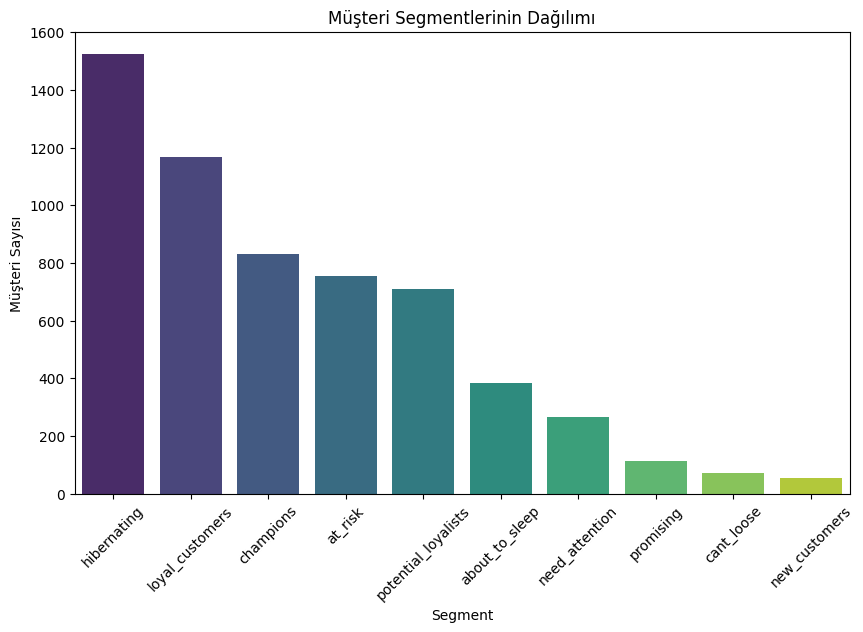

In [ ]:
def bar_plot(dataframe):

    value_counts = dataframe["segment"].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    plt.title('Müşteri Segmentlerinin Dağılımı')
    plt.xlabel('Segment')
    plt.ylabel('Müşteri Sayısı')
    plt.xticks(rotation=45)
    plt.show()

bar_plot(rfm_score)

<ipython-input-14-152aa0bfcb2d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x=rfm_score['segment'], y=rfm_score['recency'], palette='Set2')
<ipython-input-14-152aa0bfcb2d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x=rfm_score['segment'], y=rfm_score['frequency'], palette='Set2')
<ipython-input-14-152aa0bfcb2d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2], x=rfm_score['segment'], y=rfm_score['monetary'], palette='Set2')


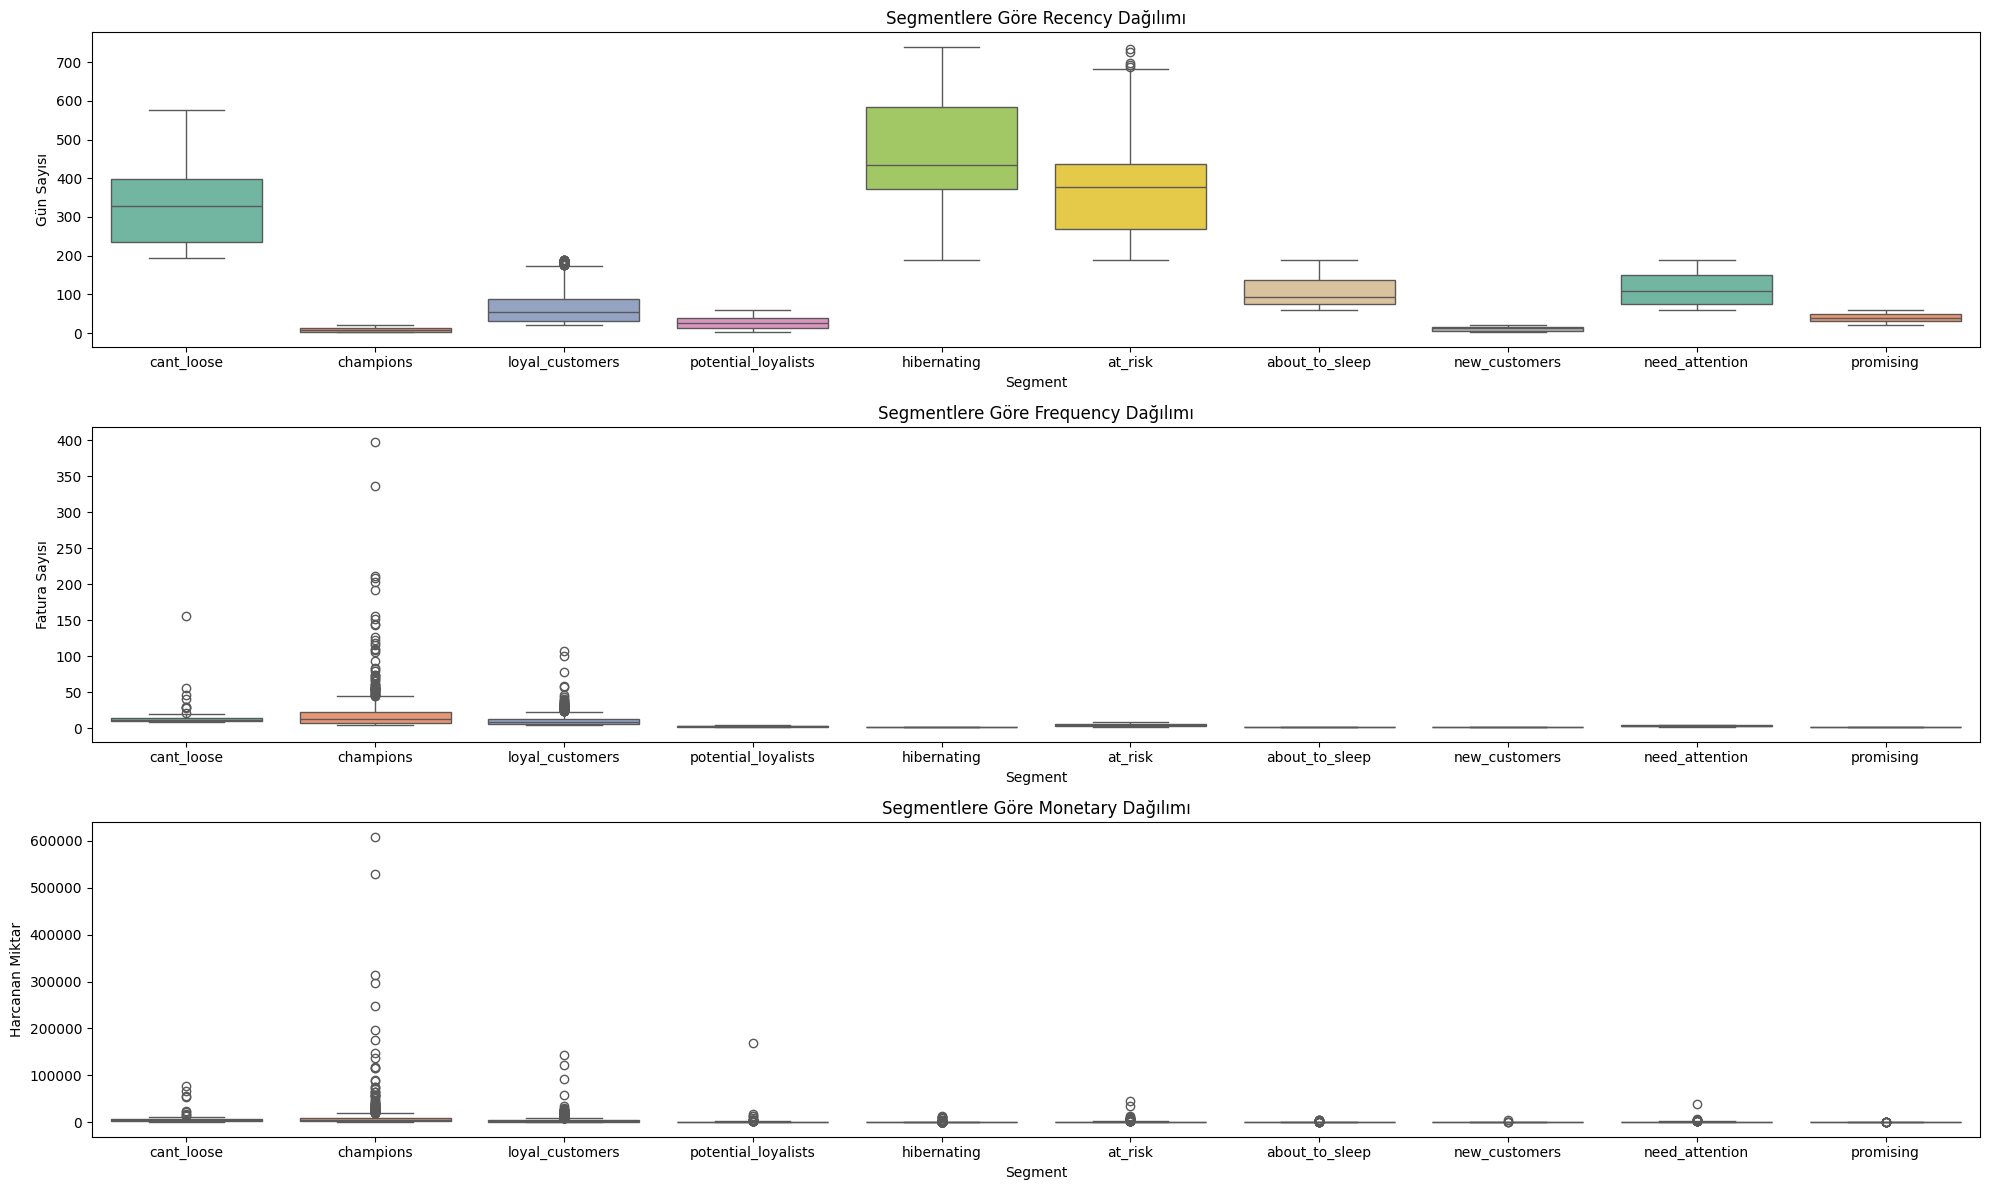

In [ ]:
# RFM metriklerinin segmentlere göre dağılımı
fig, axes = plt.subplots(3, 1, figsize=(20, 12))

# Recency
sns.boxplot(ax=axes[0], x=rfm_score['segment'], y=rfm_score['recency'], palette='Set2')
axes[0].set_title('Segmentlere Göre Recency Dağılımı')
axes[0].set_xlabel('Segment')
axes[0].set_ylabel('Gün Sayısı')

# Frequency
sns.boxplot(ax=axes[1], x=rfm_score['segment'], y=rfm_score['frequency'], palette='Set2')
axes[1].set_title('Segmentlere Göre Frequency Dağılımı')
axes[1].set_xlabel('Segment')
axes[1].set_ylabel('Fatura Sayısı')

# Monetary
sns.boxplot(ax=axes[2], x=rfm_score['segment'], y=rfm_score['monetary'], palette='Set2')
axes[2].set_title('Segmentlere Göre Monetary Dağılımı')
axes[2].set_xlabel('Segment')
axes[2].set_ylabel('Harcanan Miktar')

plt.tight_layout()
plt.show()

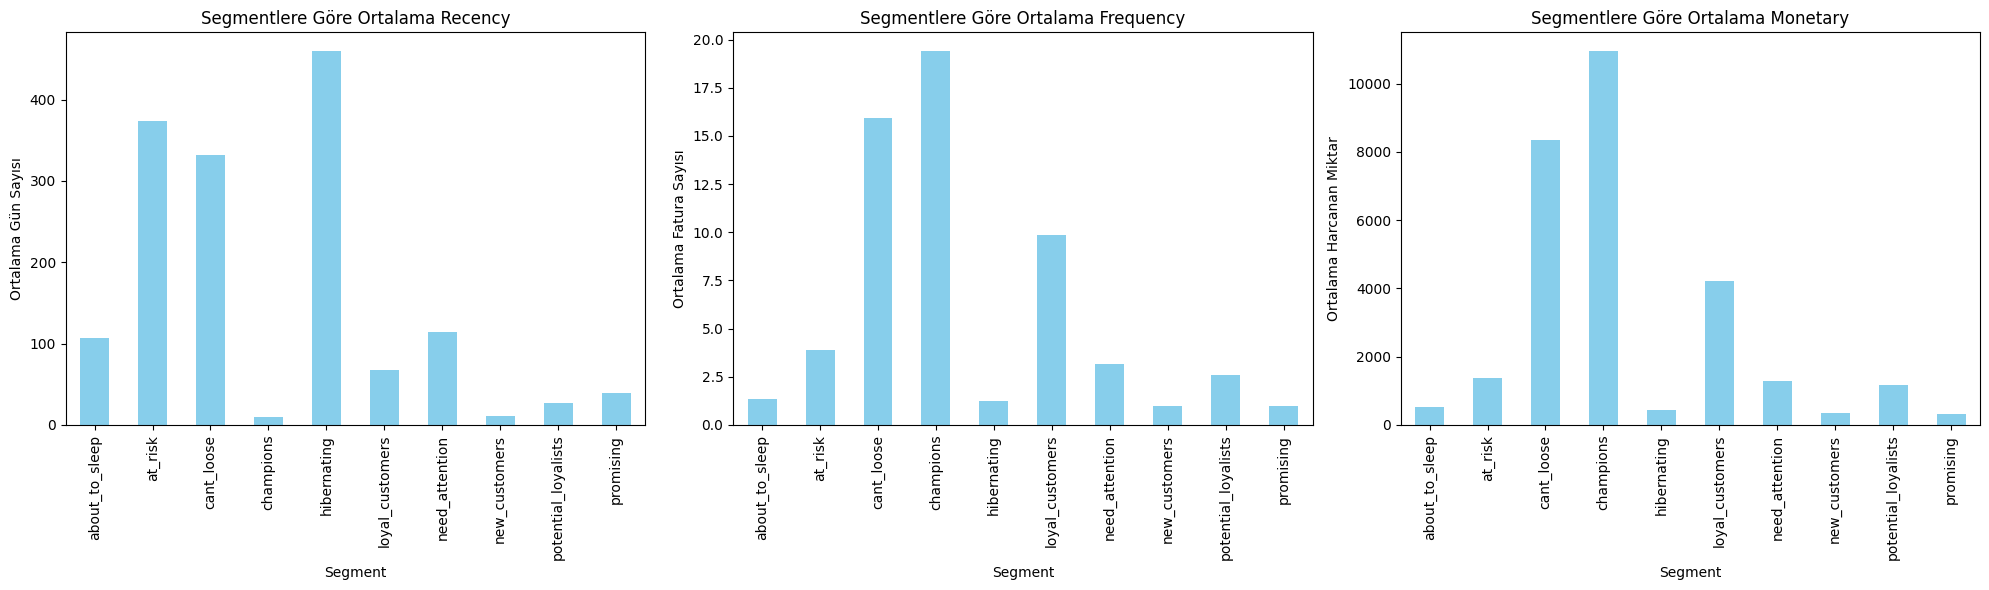

In [ ]:
# Segmentlere göre ortalama RFM metriklerini hesaplama
rfm_means = rfm_score.groupby('segment').mean()

# Bar grafikleri oluşturma
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Recency
rfm_means['recency'].plot.bar(ax=axes[0], color='skyblue')
axes[0].set_title('Segmentlere Göre Ortalama Recency')
axes[0].set_xlabel('Segment')
axes[0].set_ylabel('Ortalama Gün Sayısı')

# Frequency
rfm_means['frequency'].plot.bar(ax=axes[1], color='skyblue')
axes[1].set_title('Segmentlere Göre Ortalama Frequency')
axes[1].set_xlabel('Segment')
axes[1].set_ylabel('Ortalama Fatura Sayısı')

# Monetary
rfm_means['monetary'].plot.bar(ax=axes[2], color='skyblue')
axes[2].set_title('Segmentlere Göre Ortalama Monetary')
axes[2].set_xlabel('Segment')
axes[2].set_ylabel('Ortalama Harcanan Miktar')

plt.tight_layout()
plt.show()


In [ ]:
## Alınabilecek Aksiyonlar
rfm_score[["recency","frequency","monetary","segment"]].groupby("segment").agg(["mean","count"])

recency        frequency            monetary      
                           mean count       mean count          mean count
segment                                                                   
about_to_sleep       107.216146   384   1.361979   384    533.926102   384
at_risk              373.428382   754   3.907162   754   1381.595027   754
cant_loose           332.225352    71  15.929577    71   8355.677634    71
champions              9.472289   830  19.407229   830  10959.056380   830
hibernating          459.749672  1526   1.252949  1526    437.837419  1526
loyal_customers       67.676093  1167   9.852614  1167   4213.516628  1167
need_attention       113.951493   268   3.149254   268   1278.690485   268
new_customers         11.500000    54   1.000000    54    360.667407    54
potential_loyalists   26.616034   711   2.592124   711   1158.352716   711
promising             39.654867   113   1.000000   113    321.604602   113

##### **RF Skoru**

RFM Analizi'nde müşteri segmentasyonu yapılırken R yani Recency skoru ile F yani Frequency skorundan elde edilen RF kullanılır.

- Recency(R): Müşterilerin en son alışveriş yaptığı tarihin üzerinden kaç gün geçtiğini ifade eder. Yani kişinin last_order_date tarihinden gözlem tarihine (today_date) kaç gün olduğudur.
Recency'nin artması bizim için negatif bir durum olduğu için küçük Recency değerine sahip olan müşterilerin Recency Skoru 5 iken, çok büyük Recency değerine sahip olan müşterilerin skoru 1'dir.

- Frequency(F): Müşterilerin alışveriş yapma sıklığını ifade eder. İlgili gözlem tarihine kadar yaptığı toplam alışveriş sayısını ifade eder. Burada Frequency'nin artması pozitif bir durum yarattığı için Frequency skorları da Frequency değerleriyle doğru orantılı şekilde artmaktadır.

Skorlar 1-5 arası değişiklik göstermekte ve bu skorlardan elde edilen RF skoru ise 11-55 aralığındadır. RF skorlarının sektörde karşılık geldiği gruplar bulunmaktadır. Buna göre gruplama yapılmıştır.

Gruplara ait özellikleri ve gruplar için alınabilecek aksiyonları belirtmek için her segmentin karakteristik özelliklerini ve bu segmentlere yönelik stratejileri anlamamız gerekiyor. İşte belirlenen segmentler ve her birine yönelik alınabilecek aksiyonlar:

##### 1. **Hibernating**
- **Özellikler**:
  - Recency ve frequency skorları düşük.
  - Uzun süredir alışveriş yapmamış ve alışveriş sıklığı düşük müşteriler.
- **Aksiyonlar**:
  - Uygun indirim ve teşvikler sunarak yeniden etkileşim sağlamak.
  - E-posta kampanyaları ve hatırlatıcılar göndererek tekrar ziyaret etmelerini teşvik etmek.
  - Yenilikçi ürünler veya özel teklifler sunarak ilgilerini çekmek.

##### 2. **At Risk**
- **Özellikler**:
  - Recency skoru düşük, frequency skoru orta-yüksek.
  - Daha önce sık alışveriş yapmış ancak son zamanlarda aktif olmayan müşteriler.
- **Aksiyonlar**:
  - Sadakat programları veya özel indirimler sunarak geri kazanmaya çalışmak.
  - Anketler veya geri bildirim mekanizmaları ile neden alışveriş yapmadıklarını anlamak.
  - Kişiselleştirilmiş öneriler ve hatırlatmalar göndermek.

##### 3. **Can't Lose**
- **Özellikler**:
  - Recency skoru düşük, frequency skoru yüksek.
  - Çok sık alışveriş yapan ancak son zamanlarda aktif olmayan müşteriler.
- **Aksiyonlar**:
  - Hemen harekete geçerek özel teklifler ve yüksek değerli teşvikler sunmak.
  - VIP programlarına dahil ederek özel ayrıcalıklar tanımak.
  - Müşteri hizmetleri ile birebir iletişime geçerek memnuniyetlerini sağlamak.

##### 4. **About to Sleep**
- **Özellikler**:
  - Recency skoru orta, frequency skoru düşük.
  - Son zamanlarda bazı alışverişler yapmış ancak genel olarak aktif olmayan müşteriler.
- **Aksiyonlar**:
  - Hatırlatma e-postaları ve son fırsatlar ile tekrar alışverişe teşvik etmek.
  - Ücretsiz kargo veya küçük indirimler sunarak alışveriş yapmalarını sağlamak.
  - İlgilendikleri kategorilerde kişiselleştirilmiş öneriler sunmak.

##### 5. **Need Attention**
- **Özellikler**:
  - Hem recency hem de frequency skorları orta.
  - Potansiyeli olan ancak daha fazla ilgi ve teşvik gerektiren müşteriler.
- **Aksiyonlar**:
  - Özel promosyonlar ve indirimler sunarak alışveriş sıklıklarını artırmak.
  - Müşteri hizmetleri ile iletişim kurarak memnuniyetlerini sağlamak.
  - İlgi alanlarına göre kişiselleştirilmiş ürün önerileri sunmak.

##### 6. **Loyal Customers**
- **Özellikler**:
  - Hem recency hem de frequency skorları yüksek.
  - Düzenli olarak alışveriş yapan ve yüksek değer sağlayan müşteriler.
- **Aksiyonlar**:
  - Sadakat programlarına dahil ederek özel ayrıcalıklar tanımak.
  - Yeni ürün lansmanları ve özel etkinlikler hakkında bilgilendirmek.
  - Teşekkür e-postaları ve ödüllerle müşteri sadakatini pekiştirmek.

##### 7. **Promising**
- **Özellikler**:
  - Recency skoru yüksek, frequency skoru düşük.
  - Yakın zamanda alışveriş yapmış ancak henüz sadık müşteri olmamış müşteriler.
- **Aksiyonlar**:
  - Hoş geldin indirimleri ve teşvikler sunarak alışveriş sıklığını artırmak.
  - E-posta kampanyaları ile ilgilerini çekmek ve sadakatlerini artırmak.
  - Ücretsiz numuneler veya küçük hediyeler göndererek markaya bağlılıklarını sağlamak.

##### 8. **New Customers**
- **Özellikler**:
  - Recency skoru yüksek, frequency skoru düşük.
  - Yeni müşteriler, henüz sadık hale gelmemiş.
- **Aksiyonlar**:
  - Hoş geldin indirimleri ve özel teklifler sunmak.
  - E-posta ile takip ederek memnuniyetlerini sağlamak ve tekrar alışveriş yapmalarını teşvik etmek.
  - Ücretsiz kargo veya indirim kuponları sunarak alışveriş sıklığını artırmak.

##### 9. **Potential Loyalists**
- **Özellikler**:
  - Recency skoru yüksek, frequency skoru orta.
  - Yakın zamanda alışveriş yapmış ve sadık müşteri olma potansiyeline sahip müşteriler.
- **Aksiyonlar**:
  - Sadakat programlarına dahil ederek alışveriş sıklığını artırmak.
  - Kişiselleştirilmiş teklifler ve indirimler sunmak.
  - Müşteri memnuniyetini sağlamak için geri bildirim toplamak.

##### 10. **Champions**
- **Özellikler**:
  - Hem recency hem de frequency skorları en yüksek.
  - En değerli ve sık alışveriş yapan müşteriler.
- **Aksiyonlar**:
  - VIP programları ve özel ayrıcalıklar tanımak.
  - Yeni ürün lansmanları ve özel etkinlikler hakkında bilgilendirmek.
  - Teşekkür e-postaları ve özel ödüllerle müşteri sadakatini pekiştirmek.

Bu segmentlere yönelik stratejiler, müşteri ilişkilerini güçlendirmek ve pazarlama faaliyetlerinin etkinliğini artırmak için önemlidir. Müşteri segmentlerine yönelik kişiselleştirilmiş stratejiler, müşteri memnuniyetini ve sadakatini artırmaya yardımcı olacaktır.

# SALES PREDICTION

In [ ]:
def resample_daily_sales(df, date_column="date", target_column="TotalPrice"):
    """
    DataFrame'i günlük olarak yeniden örnekler ve toplam satışları hesaplar.

    Args:
    df (pd.DataFrame): Girdi DataFrame'i.
    date_column (str): Tarih sütununun adı.
    target_column (str): Toplam satışların hesaplanacağı sütunun adı.

    Returns:
    pd.DataFrame: Günlük toplam satışları içeren DataFrame.
    """

    df = df[[date_column, target_column]]
    df.set_index(date_column, inplace=True)

    daily_df = df.resample('D')[target_column].sum().to_frame()

    # İndeksi sıfırla ve sütun isimlerini değiştir
    daily_df = daily_df.reset_index()
    daily_df.columns = ["date", "TotalPrice"]

    return daily_df


# Mevsimleri oluşturma
def mevsimler(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in[3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    else:
        return "Autumn"

# Tarih özelliklerini oluşturma fonksiyonu
def create_date_features(df):
    """
    Verilen DataFrame'e tarihle ilgili özellikler ekler.

    Args:
    df (pd.DataFrame): Tarih sütununu içeren DataFrame.

    Returns:
    pd.DataFrame: Tarih özellikleri eklenmiş DataFrame.
    """

    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = (df.date.dt.dayofweek >= 5).astype(int)
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df["Days_name"] = df.date.dt.day_name()
    df["quarter"] = df.date.dt.quarter
    df["season"] = df["month"].apply(mevsimler)
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    return df

# Gürültü ekleme fonksiyonu
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=len(dataframe))

# Lag özellikleri fonksiyonu
def lag_features(dataframe, fh):
    """
    Verilen DataFrame'e gecikme (lag) özellikleri ekler.

    Args:
    dataframe (pd.DataFrame): Özelliklerin eklenmesi gereken DataFrame.
    fh (int): Gecikme miktarı.

    Returns:
    pd.DataFrame: Gecikme özellikleri eklenmiş DataFrame.
        Her bir gecikme değeri için 'sales_lag_' + str(fh) + '_n' sütunları eklenir,
        burada 'n' gecikme miktarını belirtir.
    """
    df_copy = dataframe.copy()
    lags = [fh + 2, fh + 6, fh + 10, fh + 12, fh + 13, fh + 16, fh + 30, fh + 46, fh + 60]
    for lag in lags:
        df_copy['sales_lag_' + str(lag)] = df_copy['TotalPrice'].shift(lag)
    return df_copy


# Yığınsal ortalama özellikleri fonksiyonu
def roll_mean_features(dataframe, fh):
    """
    Verilen DataFrame'e yığınsal ortalama (rolling mean) özellikleri ekler.

    Args:
    dataframe (pd.DataFrame): Özelliklerin eklenmesi gereken DataFrame.
    fh (int): Yığınsal ortalama pencere uzunluğu.

    Returns:
    pd.DataFrame: Yığınsal ortalama özellikleri eklenmiş DataFrame.
        Her bir pencere uzunluğu için 'TotalPrice_roll_mean_' + str(fh) sütunları eklenir.
    """
    df_copy = dataframe.copy()
    windows = [181, 365, 546]
    for window in windows:
        df_copy[f'TotalPrice_roll_mean_{window}'] = df_copy['TotalPrice'].rolling(window=window, min_periods=1).mean()
    return df_copy

# Eksponansiyel hareketli ortalama özellikleri fonksiyonu
def ewm_features(dataframe, alphas, fh):
    """
    Verilen DataFrame'e eksponansiyel hareketli ortalama (exponential weighted mean) özellikleri ekler.

    Args:
    dataframe (pd.DataFrame): Özelliklerin eklenmesi gereken DataFrame.
    alphas (list): Eksponansiyel ağırlık faktörleri listesi.
    fh (int): Gecikme miktarı.

    Returns:
    pd.DataFrame: Eksponansiyel hareketli ortalama özellikleri eklenmiş DataFrame.
        Her bir alpha değeri ve gecikme miktarı için 'TotalPrice_ewm_alpha_<alpha>_lag_<lag>' sütunları eklenir.
    """
    df_copy = dataframe.copy()
    lags = [fh + 2, fh + 6, fh + 10, fh + 12, fh + 13, fh + 16, fh + 30, fh + 46, fh + 60]
    for alpha in alphas:
        for lag in lags:
            df_copy['TotalPrice_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['TotalPrice'].shift(lag).ewm(alpha=alpha).mean()
    return df_copy


# One-hot encoding işlemleri fonksiyonu
def one_hot_encode_dataframe(dataframe):
    """
    Verilen DataFrame'in kategorik sütunlarını one-hot encoding ile dönüştürür.

    Args:
    dataframe (pd.DataFrame): One-hot encoding uygulanacak DataFrame.

    Returns:
    tuple: One-hot encoding uygulanmış DataFrame ve OneHotEncoder nesnesi tuple olarak döner.
        DataFrame, kategorik sütunları one-hot encoding ile dönüştürülmüş halde ve
        kategorik sütunlar çıkarılmış olarak içerir.
    """
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    cat_cols = [col for col in cat_cols if col != "Description"]
    ohe = OneHotEncoder(handle_unknown='ignore')
    one_hot_encoded = ohe.fit_transform(dataframe[cat_cols]).toarray()
    X_train_ohe = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(cat_cols))
    df_merged_train = pd.concat([dataframe.reset_index(drop=True), X_train_ohe.reset_index(drop=True)], axis=1)
    df_merged_train = df_merged_train.drop(cat_cols, axis=1)
    return df_merged_train, ohe

# Test verisini one-hot encoding ile dönüştürme fonksiyonu
def one_hot_encode_transform(dataframe, ohe):
    """
    Verilen DataFrame'in kategorik sütunlarını önceden fit edilmiş OneHotEncoder nesnesi ile one-hot encoding ile dönüştürür.

    Args:
    dataframe (pd.DataFrame): One-hot encoding uygulanacak DataFrame.
    ohe (OneHotEncoder): Fit edilmiş OneHotEncoder nesnesi.

    Returns:
    pd.DataFrame: One-hot encoding uygulanmış DataFrame.
        DataFrame, kategorik sütunları one-hot encoding ile dönüştürülmüş halde ve
        kategorik sütunlar çıkarılmış olarak içerir.
    """
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    cat_cols = [col for col in cat_cols if col != "Description"]
    one_hot_encoded = ohe.transform(dataframe[cat_cols]).toarray()
    X_train_ohe = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(cat_cols))
    df_merged_train = pd.concat([dataframe.reset_index(drop=True), X_train_ohe.reset_index(drop=True)], axis=1)
    df_merged_train = df_merged_train.drop(cat_cols, axis=1)
    return df_merged_train


# Korelasyon hesaplama fonksiyonu
def calculate_correlation(dataframe):
    """
    Verilen DataFrame'deki değişkenler arasındaki korelasyonu hesaplar.

    Args:
    dataframe (pd.DataFrame): Korelasyonun hesaplanacağı DataFrame.

    Returns:
    pd.DataFrame: 'TotalPrice' değişkeni ile diğer değişkenler arasındaki korelasyonu içeren DataFrame.
        Korelasyon katsayıları büyükten küçüğe sıralanmış olarak döner.
    """
    corr = dataframe.corr()
    corr_df = corr.unstack().sort_values(ascending=False)
    corr_df = pd.DataFrame(corr_df)
    corr_df.reset_index(inplace=True)
    corr_df.columns = ["var1", "var2", "corr"]
    return corr_df[(corr_df["var1"] == "TotalPrice") & (corr_df["corr"].apply(lambda x: x != 1))].head(30)


def split_train_test(dataframe):
    """
    Verilen DataFrame'i eğitim ve değerlendirme veri setlerine ayırır.

    Args:
    dataframe (pd.DataFrame): Tarih özelliklerini içeren DataFrame.

    Returns:
    tuple: Eğitim ve değerlendirme veri setlerini içeren tuple (X_train, y_train, X_val, y_val).
           X_train ve X_val, "year" ve "TotalPrice" sütunları çıkarılmıştır ve eksik değerler 0 ile doldurulmuştur.
           y_train ve y_val, sadece "TotalPrice" sütununu içerir.
    """
    train = dataframe[dataframe["date"] < "2011-11-10"]
    val = dataframe[dataframe["date"] >= "2011-11-10"]

    train.set_index("date", inplace=True)
    val.set_index("date", inplace=True)

    X_train = train.drop(["year", "TotalPrice"], axis=1).fillna(0)
    y_train = train["TotalPrice"]

    X_val = val.drop(["year", "TotalPrice"], axis=1).fillna(0)
    y_val = val["TotalPrice"]

    return X_train, y_train, X_val, y_val


In [ ]:
df.head()

,date,TotalPrice,month,day_of_month,day_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,Days_name,quarter,season,is_year_start,is_year_end
0,2009-12-01,44048.69,12,1,335,2,2009,0,1,0,Tuesday,4,Winter,0,0
1,2009-12-02,52941.99,12,2,336,3,2009,0,0,0,Wednesday,4,Winter,0,0
2,2009-12-03,67479.08,12,3,337,4,2009,0,0,0,Thursday,4,Winter,0,0
3,2009-12-04,34064.41,12,4,338,5,2009,0,0,0,Friday,4,Winter,0,0
4,2009-12-05,9803.05,12,5,339,6,2009,1,0,0,Saturday,4,Winter,0,0


In [ ]:
df_new= df.copy()

df = resample_daily_sales(df_new)
# yeni date featureların eklenmesi
df= create_date_features(df)
# lag featureların eklenmesi
merged_df = lag_features(df, 15)
merged_df = roll_mean_features(merged_df, 15)

alphas = [0.99, 0.95,0.93, 0.9, 0.8, 0.85,0.7]
merged_df = ewm_features(merged_df, alphas, 15)

# veri setnin train ve test olarak ikiye ayrılması 15 gün test için ayrılmıştır
train=merged_df[merged_df["date"]<="2011-11-24"]
test=merged_df[merged_df["date"]>"2011-11-24"]

# train seti için one-hot uygulanması
df_train,ohe= one_hot_encode_dataframe(train)

# test seti için one-hot uygulanması
df_test= one_hot_encode_transform(test,ohe)

# correlasyonlarına bakılması
calculate_correlation(df_train)

# train veri setinin train ve val olarak ayrılması val de yine 15 gün içermektedir
X_train, y_train, X_val, y_val= split_train_test(df_train)


In [ ]:
calculate_correlation(df_train)

,var1,var2,corr
1136,TotalPrice,sales_lag_21,0.448563
1140,TotalPrice,TotalPrice_ewm_alpha_099_lag_21,0.448331
1172,TotalPrice,TotalPrice_ewm_alpha_095_lag_21,0.446788
1184,TotalPrice,TotalPrice_ewm_alpha_099_lag_28,0.446129
1188,TotalPrice,sales_lag_28,0.446040
1194,TotalPrice,TotalPrice_ewm_alpha_095_lag_28,0.445885
1195,TotalPrice,TotalPrice_ewm_alpha_093_lag_21,0.445640
1200,TotalPrice,TotalPrice_ewm_alpha_093_lag_28,0.445392
1218,TotalPrice,TotalPrice_ewm_alpha_09_lag_28,0.444172
1222,TotalPrice,TotalPrice_ewm_alpha_09_lag_21,0.443434


### MODEL KURMA VE HIPERPAREMETRE OPTIMIZASYONUNUN GERÇEKLEŞTİRİLMESİ

In [ ]:
# Özelleştirilmiş hata fonksiyonları
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Model değerlendirme fonksiyonu : karşılaştırılması
def evaluate_models(X, y, models, n_splits=5):
  """
    Verilen modellerin performansını belirli sayıda çapraz doğrulama ile değerlendirir.

    Args:
    X (pd.DataFrame): Bağımsız değişkenlerin bulunduğu DataFrame.
    y (pd.Series): Bağımlı değişkenin bulunduğu Series.
    models (list): (str, estimator) tuple'ları içeren liste. Estimator, sklearn benzeri bir regresyon modeli olmalıdır.
    n_splits (int, optional): Zaman serisi çapraz doğrulama için bölme sayısı. Varsayılan değer 5.

    Returns:
    tuple: En iyi modelin adı ve performans ölçümleri içeren tuple.
        (str, dict): En iyi modelin adı ve RMSE, MAE performans ölçümleri içeren sözlük.
  """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {}

    for name, regressor in models:
        rmses, maes = [], []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)

            rmses.append(rmse(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))

        results[name] = {
            'rmse': np.mean(rmses),
            'mae': np.mean(maes)
        }
        print(f"{name} - RMSE: {results[name]['rmse']:.4f}, MAE: {results[name]['mae']:.4f}")

    # En iyi modeli MAE'ye göre seç
    best_model_name = min(results, key=lambda k: results[k]['mae'])
    best_model_performance = results[best_model_name]

    print(f"\nEn iyi model: {best_model_name} - RMSE: {best_model_performance['rmse']:.4f}, MAE: {best_model_performance['mae']:.4f}")
    return best_model_name, best_model_performance

# Model listesi
models = [
    ('LR', LinearRegression()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor(random_state=42)),
    ('RF', RandomForestRegressor(random_state=42)),
    ('GBM', GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(objective='reg:squarederror', random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42, verbose=-1))
]

# Fonksiyonu çağırma
best_model_name, best_model_performance = evaluate_models(X_train, y_train, models)

print(best_model_name)
print(best_model_performance)


LR - RMSE: 686339118903.1896, MAE: 589185742160.2065
KNN - RMSE: 15300.9543, MAE: 10594.7883
CART - RMSE: 20476.8255, MAE: 13938.9213
RF - RMSE: 13611.8838, MAE: 9215.2749
GBM - RMSE: 13560.8826, MAE: 9754.7087
XGBoost - RMSE: 15621.3406, MAE: 10495.4297
LightGBM - RMSE: 14618.8660, MAE: 10298.4094

En iyi model: RF - RMSE: 13611.8838, MAE: 9215.2749
RF
{'rmse': 13611.883812550484, 'mae': 9215.27492737288}


In [ ]:
## lets look at the RF model not include any hyperparemetre just

model = RandomForestRegressor(random_state=42)

# Modeli eğit
model.fit(X_train, y_train)

# Tahminleri yap
pred_y_3 = model.predict(X_val)

# Hata hesapla
mae = mean_absolute_error(y_val, pred_y_3)
print("Mean Absolute Error:", mae)

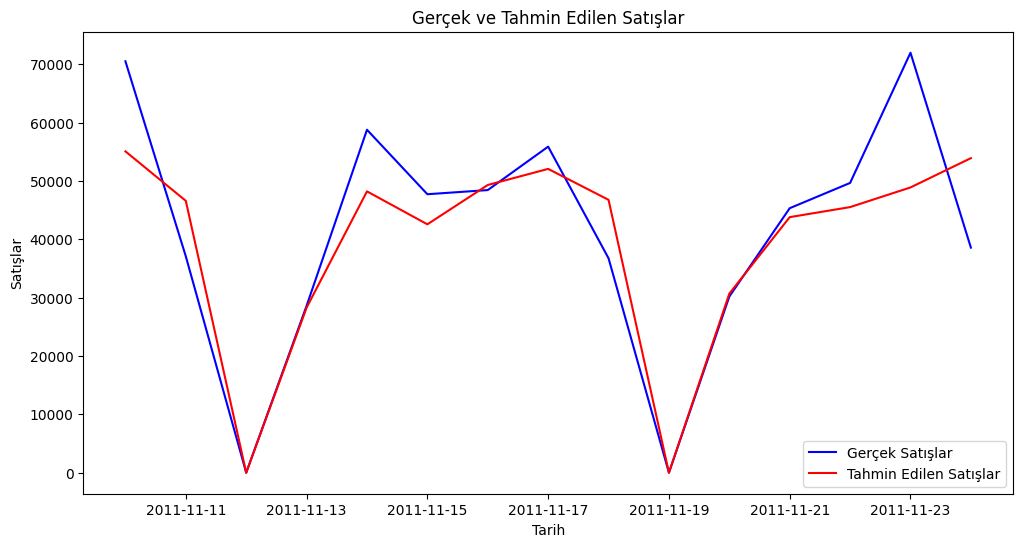

In [ ]:
def plot_sales_predictions(dates, true_sales, predicted_sales, title='Gerçek ve Tahmin Edilen Satışlar', xlabel='Tarih', ylabel='Satışlar'):
    """
    Gerçek ve tahmin edilen satışları karşılaştıran bir grafik çizer.

    Args:
    dates (pd.Series or np.ndarray): Tarih değerlerini içeren seri veya dizi.
    true_sales (pd.Series or np.ndarray): Gerçek satış değerlerini içeren seri veya dizi.
    predicted_sales (pd.Series or np.ndarray): Tahmin edilen satış değerlerini içeren seri veya dizi.
    title (str): Grafiğin başlığı.
    xlabel (str): X ekseninin etiketi.
    ylabel (str): Y ekseninin etiketi.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dates, true_sales, label='Gerçek Satışlar', color='blue')
    plt.plot(dates, predicted_sales, label='Tahmin Edilen Satışlar', color='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Fonksiyonu çağırma örneği
plot_sales_predictions(X_val.index, y_val, pred_y_3)


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


[I 2024-07-17 23:02:04,887] A new study created in memory with name: no-name-b04bee51-3cd9-4070-a976-450028f48bd0
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

En iyi hiperparametreler: {'n_estimators': 286, 'max_features': 'auto', 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 5, 'bootstrap': True}
Optimize edilmiş Mean Absolute Error (Random Forest): 7530.395876969996


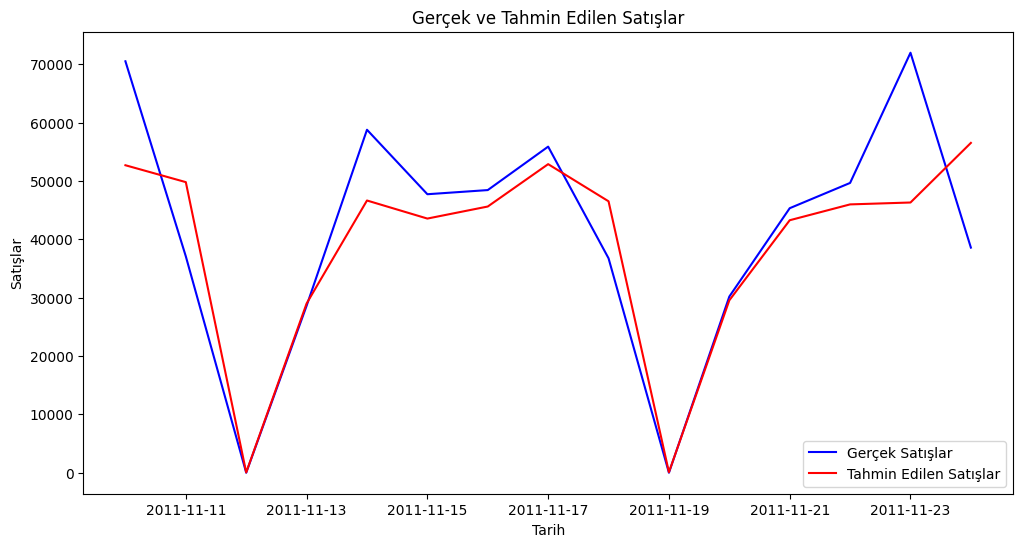

In [ ]:
## Hiperparemetre optimizasyonu

X= X_train.copy()
y= y_train.copy()
# Optuna hedef fonksiyonunu tanımla
def objective(trial):
  """

    Optuna için hedef fonksiyon. RandomForestRegressor için hiperparametre optimizasyonu yapar.

    Args:
    trial (optuna.Trial): Optuna denemesi nesnesi.

    Returns:
    float: Ortalama mutlak hata (MAE) değeri.
        TimeSeriesSplit kullanarak çapraz doğrulama sonucu elde edilen ortalama MAE değeri döner.
  """

    # Hiperparametreler
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Modeli tanımla
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42
    )

    # TimeSeriesSplit kullanarak çapraz doğrulama yap
    tscv = TimeSeriesSplit(n_splits=5)
    maes = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        maes.append(mae)

    return np.mean(maes)

# Optuna ile hiperparametre optimizasyonu yap
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

# En iyi hiperparametreleri yazdır
print("En iyi hiperparametreler:", study.best_params)

# En iyi model ile tahmin yap
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)
pred_y_rf = best_model.predict(X_val)

# Hata hesapla
mae_rf = mean_absolute_error(y_val, pred_y_rf)
print("Optimize edilmiş Mean Absolute Error (Random Forest):", mae_rf)

# Tahmin edilen ve gerçekleşen değerleri karşılaştıran grafik
plot_sales_predictions(X_val.index, y_val, pred_y_rf)



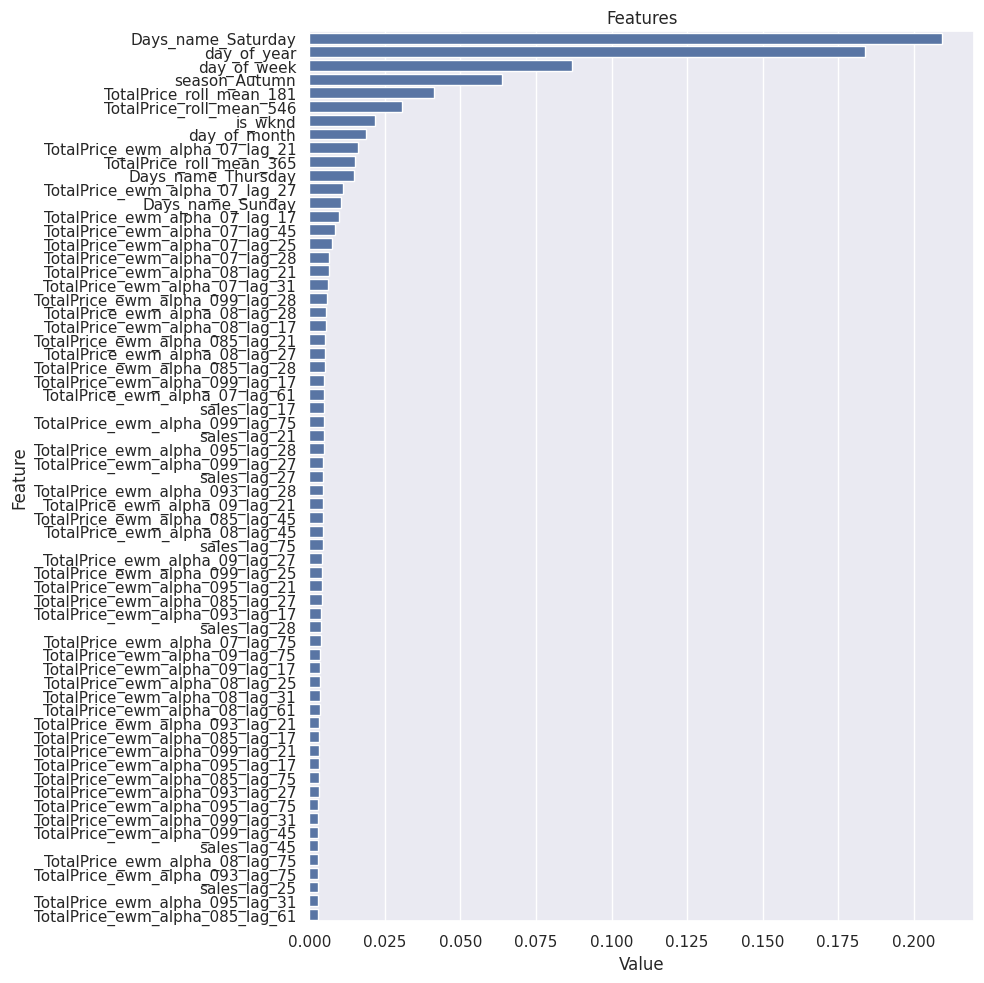

In [ ]:
def plot_importance(model, features, num=65, save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")


plot_importance(model, X)

In [ ]:
# modelde etkisi olmayan featureları çıkarıp sonra tekrar model kuralım etkisi oaacak mı olmayacak mı

Mean Absolute Error: 6801.506836666669


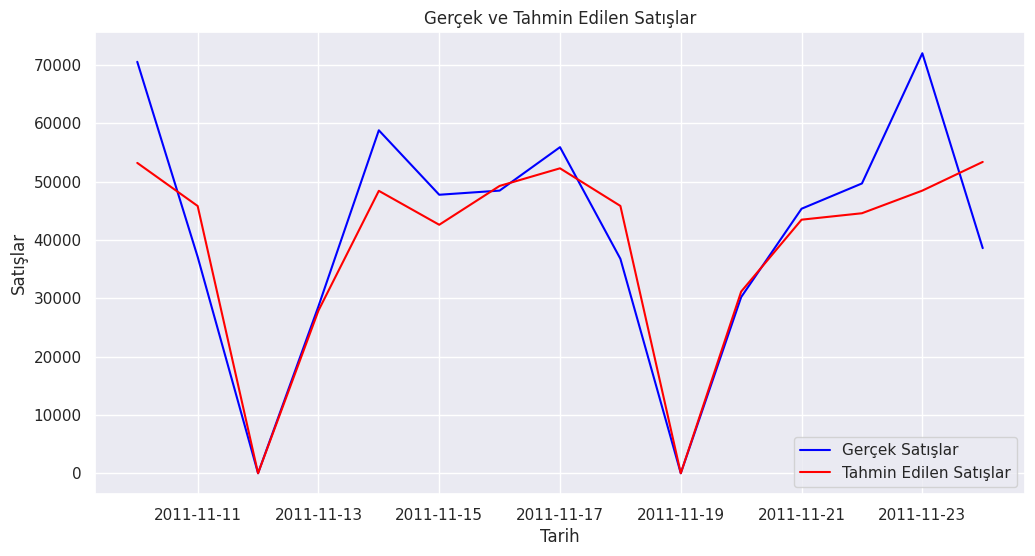

In [ ]:
importance = model.feature_importances_

zero_importance_features = X_train.columns[importance == 0]
zero_importance_features= list(zero_importance_features)

X_reduced = X_train.drop(zero_importance_features, axis=1)

val_reduced_train= X_val.drop(zero_importance_features, axis=1)

model_2 = RandomForestRegressor(random_state=42)

# Modeli eğit
model_2.fit(X_reduced, y_train)

# Tahminleri yap
pred_y_4 = model_2.predict(val_reduced_train)

# Hata hesapla
mae = mean_absolute_error(y_val, pred_y_4)
print("Mean Absolute Error:", mae)

plot_sales_predictions(X_val.index, y_val, pred_y_4)